## Bayesian Linear Regression and Posterior Predictive Simulation

# 1. Model Setup
- Input features:
$X$ (design matrix, shape $n \times p$, where each row is a data point and each column is a feature)
- Output:
$y$ (continuous target vector, e.g., house prices, shape $n$)

Assume a linear regression model:
$$
y_i = a + b_1 x_{i1} + b_2 x_{i2} + \ldots + b_p x_{ip} + \epsilon_i
$$
where
$$
\epsilon_i \sim \mathcal{N}(0, \sigma^2)
$$
or, in vector notation:
$$
y = a + X b + \epsilon
$$
where $b$ is the vector of regression coefficients.

# 2. Priors

Specify priors for the parameters:
$$
a \sim \mathcal{N}(0, 10^2)
$$
$$
b_j \sim \mathcal{N}(0, 10^2)
$$
$$
\sigma \sim \text{HalfNormal}(2)
$$

# 3. Likelihood

The likelihood:
$$
y_i \sim \mathcal{N}(a + X_i b, \sigma)
$$
where $X_i$ is the feature vector for data point $i$.

# 4. Posterior Sampling

Use MCMC (Markov Chain Monte Carlo) to sample from the posterior distribution of the parameters:
$$
p(a, b, \sigma \mid X, y)
$$
This gives you many samples (draws) of $(a, b, \sigma)$ that are plausible given the data and priors.

# 5. Posterior Predictive Simulation

For each posterior sample
$$
(a^{(s)}, b^{(s)}, \sigma^{(s)})
$$
Compute the predicted mean for a new input $x^*$:
$$
\mu^{(s)} = a^{(s)} + (x)^\top b^{(s)}
$$
Draw a simulated outcome:
$$
\tilde{y}^{(s)} \sim \mathcal{N}(\mu^{(s)}, \sigma^{(s)})
$$
Repeat for all posterior samples (and for each test point $x^*$). \
The collection of $\tilde{y}^{(s)}$ values forms the posterior predictive distribution for the response at $x^*$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('../src')
from bayesian_linear_regression import bayesian_linear_regression_posterior_predictive

sns.set(style="whitegrid")

# Load Ames Housing dataset
data = fetch_openml(name="house_prices", as_frame=True)
df = data.frame

# Use only numeric features for simplicity
numeric_features = df.select_dtypes(include=[np.number]).dropna(axis=1)
X_raw = numeric_features.drop("SalePrice", axis=1).values
y_raw = numeric_features["SalePrice"].values

# Train/Test Split (before standardization)
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.02, random_state=42
)

# Standardize (fit only on train, transform both)
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
y_train_std = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_std = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [2]:
# Run Bayesian linear regression and posterior predictive
y_pred_means_std, y_pred_stds_std, y_pred_samples_std, trace = bayesian_linear_regression_posterior_predictive(
    X_train, y_train_std, X_test, draws=500, tune=500
)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [a, b, sigma]


Output()

Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 40 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


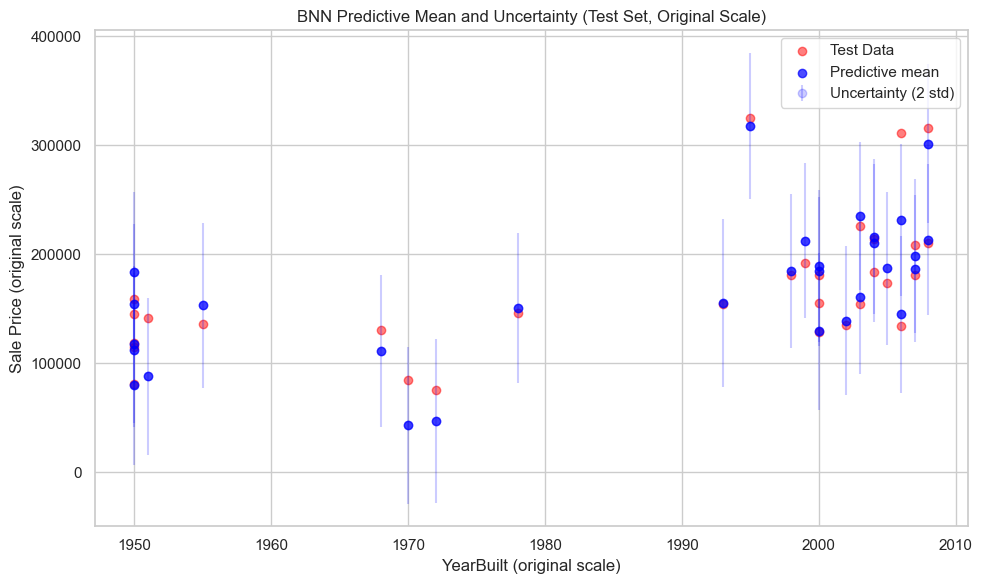

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Chosen feature to plot on the x-axis (e.g., "YearBuilt")
feature_name = "YearBuilt"
feature_idx = list(df.select_dtypes(include=[np.number]).drop("SalePrice", axis=1).columns).index(feature_name)
feature_test = X_test[:, feature_idx]

# Inverse transform predictions, stds, and test values to original scale
y_pred_means = y_scaler.inverse_transform(y_pred_means_std.reshape(-1, 1)).flatten()
y_pred_stds = y_pred_stds_std * y_scaler.scale_[0]  # stds must be rescaled, not inverse_transformed
y_test_orig = y_scaler.inverse_transform(y_test_std.reshape(-1, 1)).flatten()

# Inverse transform the feature to original scale
feature_test_orig = feature_test * X_scaler.scale_[feature_idx] + X_scaler.mean_[feature_idx]

plt.figure(figsize=(10, 6))
# actual test data
plt.scatter(feature_test_orig, y_test_orig, color='red', alpha=0.5, label='Test Data')
# predictive mean
plt.scatter(feature_test_orig, y_pred_means, color='blue', alpha=0.7, label='Predictive mean')
# uncertainty (2 std)
plt.errorbar(feature_test_orig, y_pred_means, yerr=2*y_pred_stds, fmt='o', color='blue', alpha=0.2, label='Uncertainty (2 std)')

plt.xlabel(f'{feature_name} (original scale)')
plt.ylabel('Sale Price (original scale)')
plt.title('BNN Predictive Mean and Uncertainty (Test Set, Original Scale)')
plt.legend()
plt.tight_layout()
plt.show()

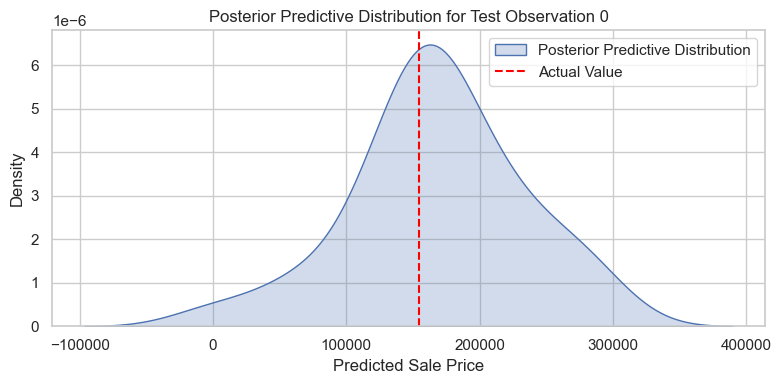

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

idx = 0  # Index of the test observation to visualize

# Get the posterior predictive samples for this observation (in standardized space)
y_pred_obs_std = y_pred_samples_std[:, idx]

# Transform back to original scale
y_pred_obs_orig = y_scaler.inverse_transform(y_pred_obs_std.reshape(-1, 1)).flatten()
y_true_orig = y_scaler.inverse_transform([[y_test_std[idx]]])[0, 0]

# Plot the predictive distribution
plt.figure(figsize=(8, 4))
sns.kdeplot(y_pred_obs_orig, fill=True, label="Posterior Predictive Distribution")
plt.axvline(y_true_orig, color='red', linestyle='--', label="Actual Value")
plt.xlabel("Predicted Sale Price")
plt.ylabel("Density")
plt.title(f"Posterior Predictive Distribution for Test Observation {idx}")
plt.legend()
plt.tight_layout()
plt.show()

# Bayesian Logistic Regression (for Binary Classification) and Posterior Predictive Simulation
## 1. Model Setup
- Input features:
$X$ (design matrix, shape $n \times p$, where each row is a data point and each column is a feature)
- Output:
$y$ (binary vector, e.g., $y_i \in \{0, 1\}$)

Assume a logistic regression model:
$$
\text{logit}(p_i) = a + b_1 x_{i1} + b_2 x_{i2} + \ldots + b_p x_{ip}
$$
or, in vector notation:
$$
\text{logit}(p_i) = a + X_i b
$$
where
$$
p_i = P(y_i = 1 \mid x_i) = \frac{1}{1 + \exp\left(- (a + X_i b)\right)}
$$
## 2. Priors
Specify priors for the parameters:
$$
a \sim \mathcal{N}(0, 10^2)
$$
$$
b_j \sim \mathcal{N}(0, 10^2)
$$
## 3. Likelihood
The likelihood for each data point is:
$$
y_i \sim \text{Bernoulli}(p_i)
$$
where $p_i$ is as defined above.
## 4. Posterior Sampling
Use MCMC (Markov Chain Monte Carlo) to sample from the posterior distribution of the parameters:
$$
p(a, b \mid X, y)
$$
This gives you many samples (draws) of $(a, b)$ that are plausible given the data and priors.
## 5. Posterior Predictive Simulation
For each posterior sample
$$
(a^{(s)}, b^{(s)})
$$
Compute the predicted probability for a new input $x^*$:
$$
p^{(s)} = \frac{1}{1 + \exp\left(- (a^{(s)} + (x^*)^\top b^{(s)})\right)}
$$
Draw a simulated class label:
$$
\tilde{y}^{(s)} \sim \text{Bernoulli}(p^{(s)})
$$
Repeat for all posterior samples (and for each test point $x^*$).\
The collection of $p^{(s)}$ values forms the posterior predictive distribution for the probability, and the collection of $\tilde{y}^{(s)}$ values forms the posterior predictive distribution for the class label.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('../src')
from bayesian_logistic_regression import bayesian_logistic_regression_posterior_predictive

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Select only Versicolor (1) and Virginica (2)
mask = (y == 1) | (y == 2)
X = X[mask]
y = y[mask]
# Relabel: Versicolor=0, Virginica=1
y = (y == 2).astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [6]:
p_pred_means, p_pred_stds, p_pred_samples, trace = bayesian_logistic_regression_posterior_predictive(
    X_train_std, y_train, X_test_std, draws=1000, tune=1000, chains=2, random_seed=42
)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
There were 979 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


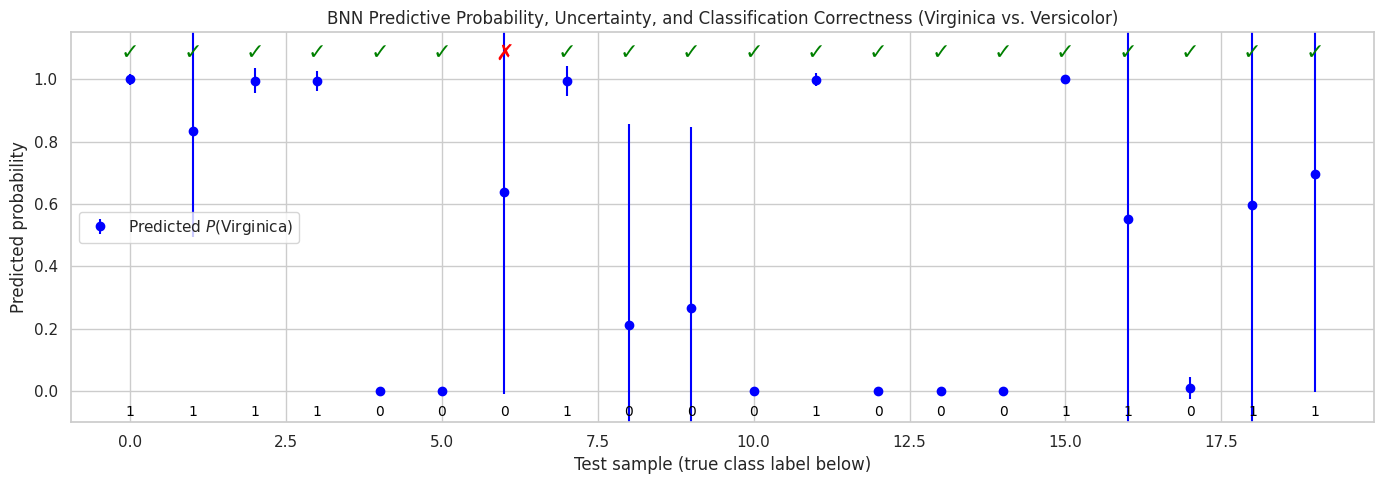

In [9]:
y_pred = (p_pred_means > 0.5).astype(int)
correct = y_pred == y_test

plt.figure(figsize=(14, 5))
plt.rcParams['font.family'] = 'DejaVu Sans'
x = np.arange(len(y_test))
plt.errorbar(
    x, p_pred_means, yerr=2*p_pred_stds, fmt='o', color='blue', label='Predicted $P$(Virginica)'
)
for i, (yt, yp) in enumerate(zip(y_test, y_pred)):
    color = 'green' if yt == yp else 'red'
    marker = '✓' if yt == yp else '✗'
    plt.text(i, 1.05, marker, color=color, fontsize=16, ha='center', va='bottom', fontweight='bold')
    plt.text(i, -0.08, f"{yt}", color='black', ha='center', fontsize=10)
plt.ylim(-0.1, 1.15)
plt.xlabel("Test sample (true class label below)")
plt.ylabel("Predicted probability")
plt.title("BNN Predictive Probability, Uncertainty, and Classification Correctness (Virginica vs. Versicolor)")
plt.legend()
plt.tight_layout()
plt.show()

# Bayesian Multiclass Logistic Regression (for Multiclass Classification) and Posterior Predictive Simulation
## 1. Model Setup
- Input features:
$X$ (design matrix, shape $n \times p$, where each row is a data point and each column is a feature)
- Output:
$y$ (categorical vector, $y_i \in \{0, 1, \ldots, K-1\}$ for $K$ classes)

Assume a multinomial logistic regression (softmax regression) model: For each class $k = 0, 1, \ldots, K-1$:

$$
\text{logit}_k(x_i) = a_k + b_{1k} x_{i1} + b_{2k} x_{i2} + \ldots + b_{pk} x_{ip}
$$

or, in vector notation:

$$
\text{logit}_{ik} = a_k + X_i B_k
$$

The probability for class $k$ is:
$$
p_{ik} = P(y_i = k \mid x_i) = \frac{\exp(\text{logit}_k(x_i))}{\sum_{j=0}^{K-1} \exp(\text{logit}_j(x_i))}
$$

## 2. Priors
Specify priors for the parameters:
$$
a_k \sim \mathcal{N}(0, 1)
$$
$$
b_{jk} \sim \mathcal{N}(0, 1)
$$
for all $j = 1, \ldots, p$ and $k = 0, \ldots, K-1$.

## 3. Likelihood
The likelihood for each data point is:
$$
y_i \sim \text{Categorical}(p_i)
$$
where $p_i = (p_{i0}, p_{i1}, \ldots, p_{i,K-1})$ is the vector of class probabilities for $x_i$.

## 4. Posterior Sampling
Use MCMC (Markov Chain Monte Carlo) to sample from the posterior distribution of the parameters:
$$
p(a, B \mid X, y)
$$
This gives you many samples (draws) of $(a, B)$ that are plausible given the data and priors.

## 5. Posterior Predictive Simulation
For each posterior sample
$$
(a^{(s)}, B^{(s)})
$$
Compute the predicted class probabilities for a new input $x^*$:
$$
p^{(s)}_k = \frac{\exp(a^{(s)}_k + (x^*)^\top b^{(s)}_k)}{\sum_{j=0}^{K-1} \exp(a^{(s)}_j + (x^*)^\top b^{(s)}_j)}
$$
for each class $k$.

Draw a simulated class label:
$$
\tilde{y}^{(s)} \sim \text{Categorical}(p^{(s)})
$$
Repeat for all posterior samples and for each test point $x^*$. \
The collection of $p^{(s)}$ vectors forms the posterior predictive distribution for the class probabilities, and the collection of $\tilde{y}^{(s)}$ values forms the posterior predictive distribution for the class label.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from bayesian_multiclass_logistic_regression import bayesian_multiclass_logistic_regression_posterior_predictive
import sys
sys.path.append('../src')

# Load Iris data
iris = load_iris()
X = iris.data
y = iris.target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [11]:
# Bayesian multinomial logistic regression
p_pred_means, p_pred_stds, p_pred_samples, trace = bayesian_multiclass_logistic_regression_posterior_predictive(
    X_train_std, y_train, X_test_std, draws=2000, tune=1000, chains=4, random_seed=42
)

/opt/anaconda3/envs/bnns/lib/python3.13/site-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [coefs, intercept]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


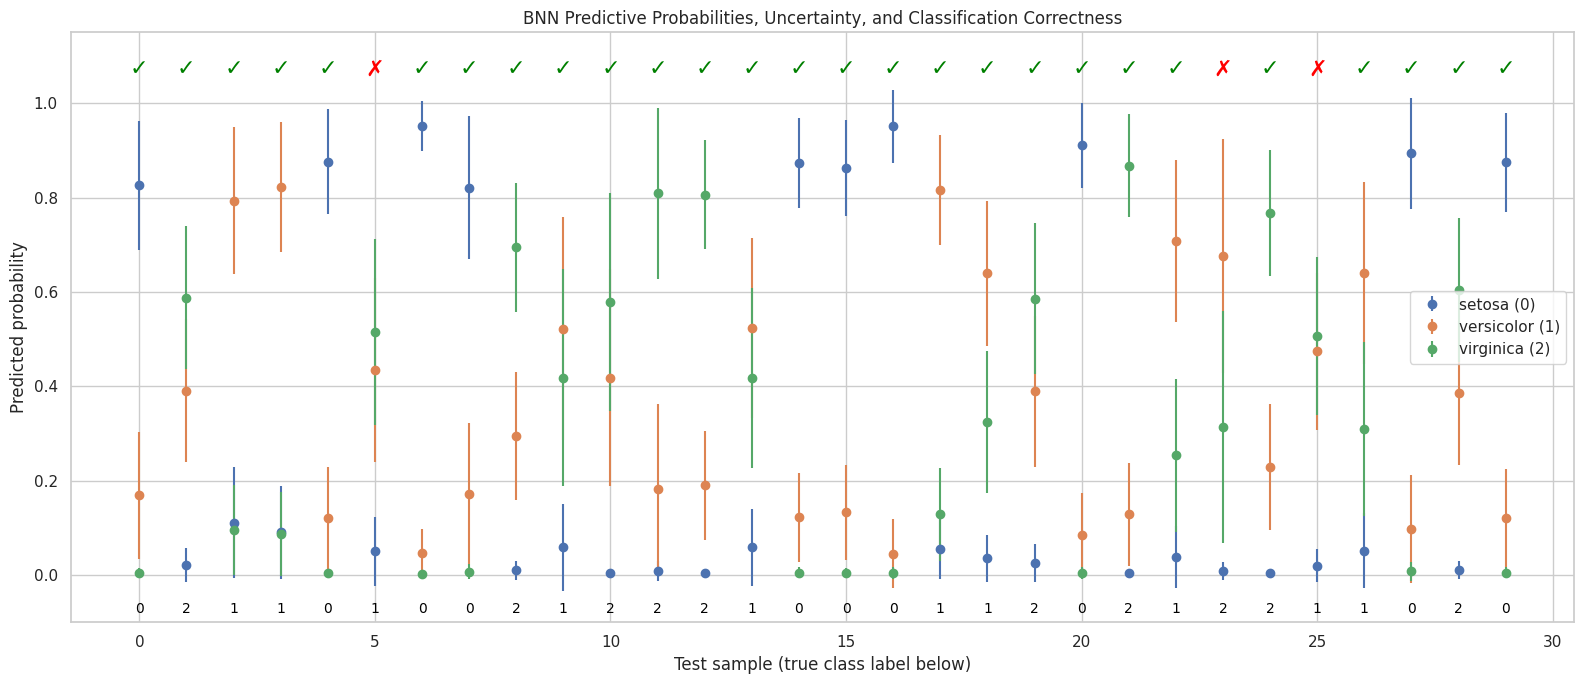

In [12]:
# Predicted class and correctness
y_pred = np.argmax(p_pred_means, axis=1)
correct = y_pred == y_test

# Plot
plt.figure(figsize=(16, 7))
x = np.arange(len(y_test))
class_names = iris.target_names
colors = ['C0', 'C1', 'C2']

for c in range(3):
    plt.errorbar(
        x, p_pred_means[:, c], yerr=2*p_pred_stds[:, c], fmt='o', color=colors[c], label=f'{class_names[c]} ({c})'
    )

# True class labels on x-axis
for i, (yt, yp) in enumerate(zip(y_test, y_pred)):
    color = 'green' if yt == yp else 'red'
    marker = '✓' if yt == yp else '✗'
    plt.text(i, 1.05, marker, color=color, fontsize=16, ha='center', va='bottom', fontweight='bold')
    plt.text(i, -0.08, f"{yt}", color='black', ha='center', fontsize=10)
plt.ylim(-0.1, 1.15)
plt.xlabel("Test sample (true class label below)")
plt.ylabel("Predicted probability")
plt.title("BNN Predictive Probabilities, Uncertainty, and Classification Correctness")
plt.legend()
plt.tight_layout()
plt.show()

# Bayesian Gaussian Mixture Model (for Unsupervised Learning) and Posterior Predictive Simulation
## 1. Model Setup
- Input data:
$X$ (data matrix, shape $n \times d$, where each row is a data point and each column is a feature)

Assume a Gaussian mixture model with $K$ components (clusters):
For each data point $i$:
Assign a latent cluster label $z_i \in \{0, 1, \ldots, K-1\}$

The generative process:
$$
\begin{align}
\pi &\sim \text{Dirichlet}(\alpha) \\
z_i &\sim \text{Categorical}(\pi) \\
\mu_k &\sim \mathcal{N}(0, 10^2) \\
\sigma_k &\sim \text{HalfNormal}(1) \\
x_i &\sim \mathcal{N}(\mu_{z_i}, \sigma_{z_i}^2)
\end{align}
$$
where:
- $\pi$ are the mixture weights (probabilities for each cluster)
- $z_i$ is the latent cluster assignment for data point $i$
- $\mu_k$ and $\sigma_k$ are the mean and standard deviation for cluster $k$
## 2. Priors
Mixture weights:
$$
\pi \sim \text{Dirichlet}(\alpha)
$$
Cluster assignments:
$$
z_i \sim \text{Categorical}(\pi)
$$
Cluster means:
$$
\mu_k \sim \mathcal{N}(0, 10^2)
$$
Cluster standard deviations:
$$
\sigma_k \sim \text{HalfNormal}(1)
$$

## 3. Likelihood
For each data point $i$:
$$
x_i \sim \mathcal{N}(\mu_{z_i}, \sigma_{z_i}^2)
$$
where 
$z_i$ is the latent cluster assignment.
## 4. Posterior Sampling
Use MCMC (Markov Chain Monte Carlo) to sample from the posterior distribution of the parameters and latent variables:
$$
p(\pi, \{\mu_k\}, \{\sigma_k\}, \{z_i\} \mid X)
$$
This gives you many samples (draws) of all parameters and assignments that are plausible given the data and priors.
## 5. Posterior Predictive Simulation

For each posterior sample:

- Sample a cluster $z^∗ \sim \text{Categorical}(\pi)$
- Sample a new data point:
$$
x^* \sim \mathcal{N}(\mu_{z^*}, \sigma_{z^*}^2)
$$
Repeat for all posterior samples. 

The collection of $x^*$
  values forms the posterior predictive distribution for new data points.


# TODO
The Posterior Predictive step is not implemented in the example below yet! 

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from scipy.stats import mode
import sys
sys.path.append('../src')
from bayesian_gaussian_mixture import bayesian_gaussian_mixture_clustering

# Load the Iris dataset (ignore labels for unsupervised clustering)
iris = load_iris()
X = iris.data  # shape (150, 4)
y_true = iris.target 

# 2 Reduce to 2D for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

In [9]:
# Fit Bayesian GMM (let's try 3 clusters, as in the true data)
trace, cluster_assignments = bayesian_gaussian_mixture_clustering(
    X_2d, n_components=3, draws=500, tune=500, chains=3, random_seed=42
)



Sequential sampling (3 chains in 1 job)
CompoundStep
>NUTS: [pi, mus, sigmas]
>CategoricalGibbsMetropolis: [category]


Output()

Sampling 3 chains for 500 tune and 500 draw iterations (1_500 + 1_500 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [11]:
# Get the most probable cluster assignment for each point (posterior mode)
assignments_flat = cluster_assignments.reshape(-1, cluster_assignments.shape[-1])
final_assignments = mode(assignments_flat, axis=0).mode.flatten()

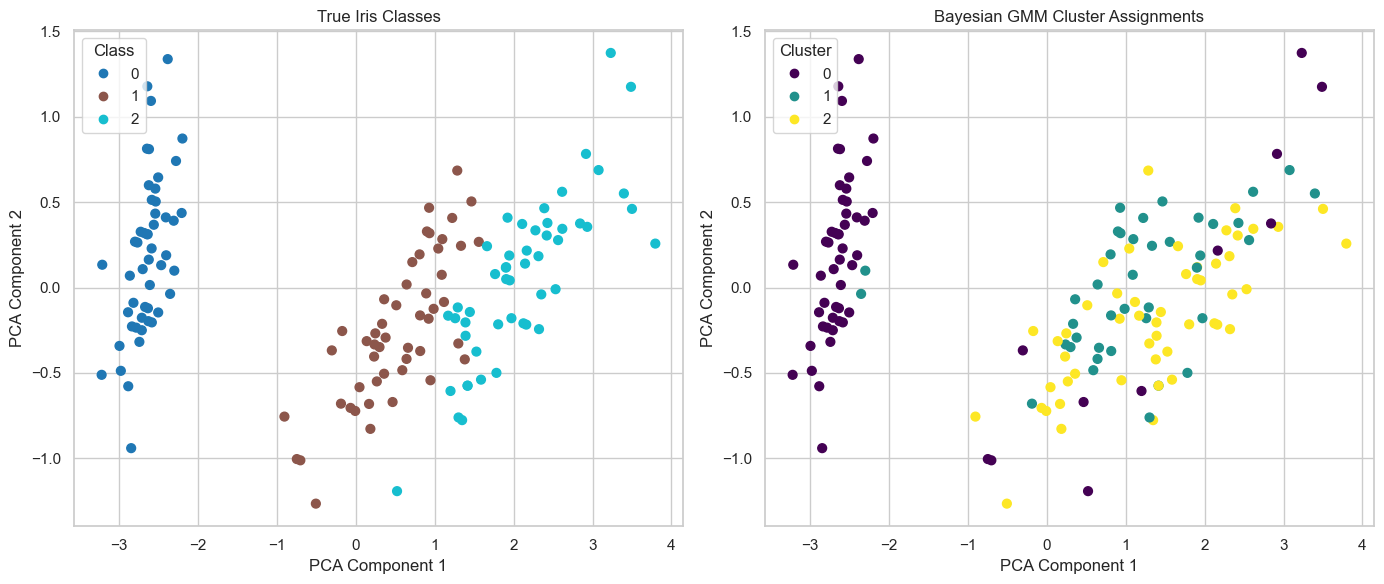

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Left: True labels
scatter1 = axs[0].scatter(X_2d[:, 0], X_2d[:, 1], c=y_true, cmap='tab10', s=40)
axs[0].set_title("True Iris Classes")
axs[0].set_xlabel("PCA Component 1")
axs[0].set_ylabel("PCA Component 2")
axs[0].legend(*scatter1.legend_elements(), title="Class")

# Right: Cluster assignments from Bayesian GMM
scatter2 = axs[1].scatter(X_2d[:, 0], X_2d[:, 1], c=final_assignments, cmap='viridis', s=40)
axs[1].set_title("Bayesian GMM Cluster Assignments")
axs[1].set_xlabel("PCA Component 1")
axs[1].set_ylabel("PCA Component 2")
axs[1].legend(*scatter2.legend_elements(), title="Cluster")

plt.tight_layout()
plt.show()

# TODO
implement in JAX instead. Much faster

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('../src')
from bayesian_linear_regression_jax import bayesian_linear_regression_posterior_predictive_jax

sns.set(style="whitegrid")

# Load Ames Housing dataset
data = fetch_openml(name="house_prices", as_frame=True)
df = data.frame

# Use only numeric features for simplicity
numeric_features = df.select_dtypes(include=[np.number]).dropna(axis=1)
X_raw = numeric_features.drop("SalePrice", axis=1).values
y_raw = numeric_features["SalePrice"].values

# Train/Test Split (before standardization)
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.02, random_state=42
)

# Standardize (fit only on train, transform both)
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
y_train_std = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_std = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [5]:
# Run Bayesian linear regression and posterior predictive
y_pred_means_std, y_pred_stds_std, y_pred_samples_std, trace = bayesian_linear_regression_posterior_predictive_jax(
    X_train, y_train_std, X_test, draws=500, tune=500, chains=1, random_seed=42
)

sample: 100%|██████████| 1000/1000 [00:11<00:00, 89.92it/s, 1023 steps of size 1.37e-03. acc. prob=0.90]


### Takes 11s to finish run using JAX vs 42s using PYMC

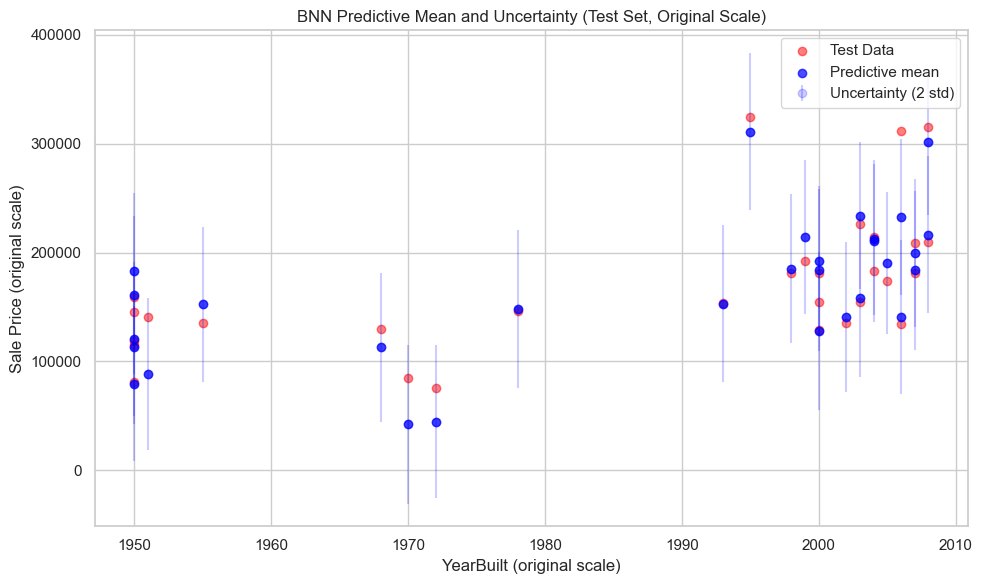

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Chosen feature to plot on the x-axis (e.g., "YearBuilt")
feature_name = "YearBuilt"
feature_idx = list(df.select_dtypes(include=[np.number]).drop("SalePrice", axis=1).columns).index(feature_name)
feature_test = X_test[:, feature_idx]

# Inverse transform predictions, stds, and test values to original scale
y_pred_means = y_scaler.inverse_transform(y_pred_means_std.reshape(-1, 1)).flatten()
y_pred_stds = y_pred_stds_std * y_scaler.scale_[0]  # stds must be rescaled, not inverse_transformed
y_test_orig = y_scaler.inverse_transform(y_test_std.reshape(-1, 1)).flatten()

# Inverse transform the feature to original scale
feature_test_orig = feature_test * X_scaler.scale_[feature_idx] + X_scaler.mean_[feature_idx]

plt.figure(figsize=(10, 6))
# actual test data
plt.scatter(feature_test_orig, y_test_orig, color='red', alpha=0.5, label='Test Data')
# predictive mean
plt.scatter(feature_test_orig, y_pred_means, color='blue', alpha=0.7, label='Predictive mean')
# uncertainty (2 std)
plt.errorbar(feature_test_orig, y_pred_means, yerr=2*y_pred_stds, fmt='o', color='blue', alpha=0.2, label='Uncertainty (2 std)')

plt.xlabel(f'{feature_name} (original scale)')
plt.ylabel('Sale Price (original scale)')
plt.title('BNN Predictive Mean and Uncertainty (Test Set, Original Scale)')
plt.legend()
plt.tight_layout()
plt.show()